In [ ]:
# Goal: Make a end-to-end analysis of a dataset

# This DOHMH Pool Inspections dataset was downloaded from NYC Opendata.
# The data was provided by: Department of Health and Mental Hygiene, Office of Public Health Engineering
# The link to the About Page: https://data.cityofnewyork.us/Health/DOHMH-Pool-Inspections/3kfa-rvez 

# According to the user guide available in the webpage's attachments: 
# In NYC, a permit is required to construct or operate bathing establishments with pools (including Saunas, Steam Rooms, Spray Grounds)
# whether they're owned by city agencies, public/private schools, corporations, hotels, motels, camps, apartments, condominiums, clubs, gyms, etc.
# This dataset contains only the pool inspections for 2019.

# My assumption: By pool inspections, it seems to refers to both the pool and the other bathing establishments in the same location.
# The data contains quantities of violations, but what kind of violations they are is not included in the data. 
# It only includes categories of violations: Critical, General, PHH, All
# Google search says pool inspections involve: space, health, filtration, disinfection, hazards, sewage, stairs/walkways, construction, circulation, etc.

# The dataset was last updated November 4th, 2021 (but only has 2019 data) 
# According to the site, It has 25 columns, 1,267 rows, with each row being a NYC Pool Inspection

# My research Question: When and which of NYC's pools and bathing establishments should be avoided?

# My hypothesis: I assume that during winter, the locations by the edges of the 5 boroughs, will have the most violations, and thus, should be avoided. 
# Because it is possible that less people visit edge areas, and workers may get lazier when the weather is cold. 

In [ ]:
# fetching/storing the data || downloading the csv file
!curl https://data.cityofnewyork.us/api/views/3kfa-rvez/rows.csv?accessType=DOWNLOAD -o pool_inspections.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  252k    0  252k    0     0   663k      0 --:--:-- --:--:-- --:--:--  663k


In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap

In [ ]:
# turning the csv file into a dataframe
pool_inspections = pd.read_csv("pool_inspections.csv")
pool_inspections.head(3)

,Permit_Type,ACCELA,Facility_Name,ADDRESS_ No,ADDRESS_St,BO,ZIP,Inspection_Date,Inspection_Type,# of All Violations,# of PHH Violations,# of Critical Violations,# of General Violations,DOCKET,Lat,Long,X,Y,X_Property_Coordinate,Y_Property_Coordinate,Community Board,Council District,Census tract,BIN,NTA
0,Indoor,40000005,SUNY MARITIME (STATE FACILITY),6,PENNYFIELD AVENUE,BX,10465,09/18/2019,Routine Inspection,2,0,1,1,NaN,40.809103,-73.801250,1039269.0,234120.0,1040948.0,233334.0,10.0,13.0,118.0,2100430.0,Schuylerville-Throgs Neck-Edgewater Park
1,Indoor,40000014,BROOKLYN CHILDREN PSYCH. CENTER (STATE FACILITY),1819,BERGEN STREET,BK,11233,12/11/2019,Routine Inspection,3,0,2,1,NaN,40.674535,-73.921262,1006091.0,185040.0,1006257.0,185174.0,16.0,41.0,303.0,3038839.0,Ocean Hill
2,Indoor,40000035,FIORELLA H. LAGUARDIA COMMUNITY COLLEGE,31-10,THOMPSON AVENUE,QU,11101,05/31/2019,Routine Inspection,2,0,1,1,NaN,40.744895,-73.935022,1002255.0,210671.0,1002221.0,210327.0,2.0,26.0,179.0,4003534.0,Hunters Point-Sunnyside-West Maspeth


In [ ]:
# checking the number of rows and columns
print(pool_inspections.shape) # matches with what the Opendata webpage says
print("number of pool inspections in 2019 is", len(pool_inspections))

(1267, 25)
number of pool inspections in 2019 is 1267


In [ ]:
# checking the columns
pool_inspections.columns

### According to the Opendata webpage, the vague column names:
# ACCELA means: the permit number
# ADDRESS_ No means: the building number
# BO means: Borough
# # of PHH Violations means: number of public health hazard violations
# DOCKET is: an unique identifier for a summons
# Lat is: Latitude && Long is: Longitude
# X && Y are: surface points on the map based on its coordinate system
# X_Property_Coordinate && Y_Property_Coordinate are: surface points on the map based on its coordinate system, relative to the properties (?)
# BIN && NTA: do not have an explanation

Index(['Permit_Type', 'ACCELA', 'Facility_Name', 'ADDRESS_ No', 'ADDRESS_St',
       'BO', 'ZIP', 'Inspection_Date', 'Inspection_Type',
       '# of All Violations', '# of PHH Violations',
       '# of Critical Violations', '# of General Violations', 'DOCKET', 'Lat',
       'Long', 'X', 'Y', 'X_Property_Coordinate', 'Y_Property_Coordinate',
       'Community Board', 'Council District', 'Census tract', 'BIN', 'NTA'],
      dtype='object')

In [ ]:
pool_inspections.dtypes

Permit_Type                  object
ACCELA                        int64
Facility_Name                object
ADDRESS_ No                  object
ADDRESS_St                   object
BO                           object
ZIP                           int64
Inspection_Date              object
Inspection_Type              object
# of All Violations           int64
# of PHH Violations           int64
# of Critical Violations      int64
# of General Violations       int64
DOCKET                       object
Lat                         float64
Long                        float64
X                           float64
Y                           float64
X_Property_Coordinate       float64
Y_Property_Coordinate       float64
Community Board             float64
Council District            float64
Census tract                float64
BIN                         float64
NTA                          object
dtype: object

In [ ]:
# changing Inspection_Date to type datetime in preparation for time series analysis
pool_inspections['Inspection_Date'] = pd.to_datetime(pool_inspections['Inspection_Date'])

In [ ]:
print(pool_inspections["Facility_Name"].value_counts())
# I thought that some facilities have many counts was because they have been inspected many times, 
# but i forgot that companies can have branches

TOWN SPORTS INTERNATIONAL        36
24 HOUR FITNESS USA INC          19
YMCA OF GREATER NEW YORK         15
TOWN SPORTS INTERNATIONAL LLC    13
PARK AVENUE HEALTH CLUB LLC      11
                                 ..
BRONXWORKS INC                    1
SVF KENT BROOKLYN CORPORATION     1
NYCP&R / DAVID FOX PARK           1
AURA WELLNESS SPA CORP            1
CDL(NEW YORK) LTD. L.P.           1
Name: Facility_Name, Length: 829, dtype: int64


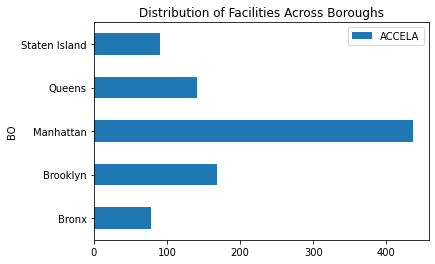

In [ ]:
# How many facilities were inspected? To check balance in dataset / data gathering

pool_inspections['BO'] = pool_inspections['BO'].replace(['MA','BK','BX','QU','SI'],['Manhattan','Brooklyn','Bronx','Queens','Staten Island'])

pool_inspections_rda = pool_inspections.drop_duplicates('ACCELA') 
#pool_inspections_rda
# not dropping by 'Facility_Name' b/c there are branch facilities w/ the same name. using 'ACCELA' instead, because that is a permit code unique to each facility
table0 = pd.pivot_table(data=pool_inspections_rda, 
                        index='BO', 
                        values=['ACCELA'], 
                        aggfunc='count')
table0.plot(kind='barh', title='Distribution of Facilities Across Boroughs')
# ...Manhattan has too many facilities compared to other boroughs. Seems unbalanced.
# Or are there simply more bathing establishments set up in Manhattan? Data doesn't tell. 

In [ ]:
# Which Facilities with least and most # of violations?
table1 = pd.pivot_table(data=pool_inspections, 
                        index=['Facility_Name','ACCELA','BO'],
                        values=['# of All Violations','# of PHH Violations','# of Critical Violations','# of General Violations'], 
                        aggfunc=np.sum)

#table1
table1.sort_values('# of All Violations')

,,,# of All Violations,# of Critical Violations,# of General Violations,# of PHH Violations
Facility_Name,ACCELA,BO,,,,
ZWIN VANDERBILT ASSOCIATES,40425650,Manhattan,0,0,0,0
POOL DE POINT LLC,41644808,Queens,0,0,0,0
EQUINOX 196 ORCHARD STREET INC,50092131,Manhattan,0,0,0,0
PREMEIR HOUSE INC,40426257,Brooklyn,0,0,0,0
EQUINOX 120 WEST 42 STREET INC,50046557,Manhattan,0,0,0,0
...,...,...,...,...,...,...
TCR TENNIS CLUB OF RIVERDALE INC,41380939,Bronx,13,4,5,4
FITNESS INTERNATIONAL LLC,50033544,Queens,16,4,4,8
L. A. FITNESS INTERNATIONAL LLC,41269465,Staten Island,16,5,7,4


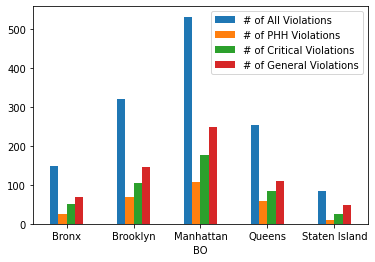

In [ ]:
# How do the sum of violations compare between boroughs?
table2 = pd.pivot_table(data=pool_inspections, 
                        index='BO', 
                        values=['# of All Violations','# of PHH Violations','# of Critical Violations','# of General Violations'], 
                        aggfunc=np.sum)

table2[['# of All Violations','# of PHH Violations','# of Critical Violations','# of General Violations']].plot(kind='bar', rot=0) # rot=0 prevents x labels rotating
# This could just be another reflection of population (of facilities) - might not be much point in this question

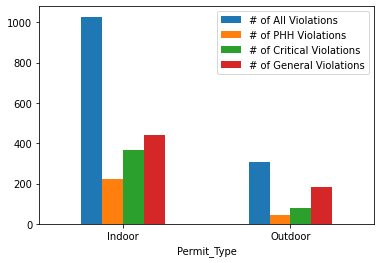

In [ ]:
# Do indoor or outdoor pools (and their related bathing establishments) have more violations?
table3 = pd.pivot_table(data=pool_inspections, 
                        index='Permit_Type', 
                        values=['# of All Violations','# of PHH Violations','# of Critical Violations','# of General Violations'], 
                        aggfunc=np.sum)
table3[['# of All Violations','# of PHH Violations','# of Critical Violations','# of General Violations']].plot(kind='bar', rot=0)
# It seems that indoor pools have more violations... 
# Is it that people are more willing to violate rules when away from public eyes?
# or that there are just more indoor pools than outdoor pools?

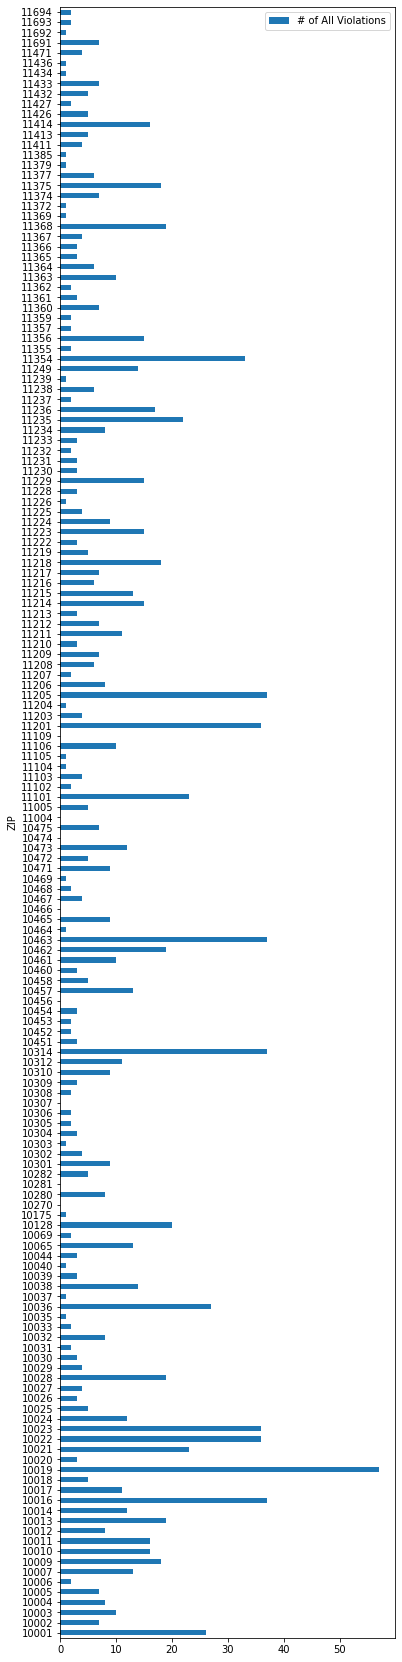

In [ ]:
# Which Zip code have the most Violations?
table5 = pd.pivot_table(data=pool_inspections, 
                        index='ZIP', 
                        values=['# of All Violations'], 
                        aggfunc=np.sum)
table5[['# of All Violations']].plot(kind='barh', figsize=(6,30))
# Result: The pools and bathing establishments at Zip code 10019 has the most Violations and are not safe.

In [ ]:
# Does the violation count change depending on time of year?
# preparing for time series analysis
table4= pd.pivot_table(data=pool_inspections,
                       index='Inspection_Date',
                       values=['# of All Violations','# of PHH Violations','# of Critical Violations','# of General Violations'],
                       aggfunc=np.sum)

#table4.resample('D').sum() # fills in empty dates with zeros
table4 = table4.resample('W').sum() # aggregating by week
table4.head()

,# of All Violations,# of Critical Violations,# of General Violations,# of PHH Violations
Inspection_Date,,,,
2019-01-06,23,10,9,4
2019-01-13,30,14,11,5
2019-01-20,17,8,6,3
2019-01-27,33,10,14,9
2019-02-03,33,9,21,3


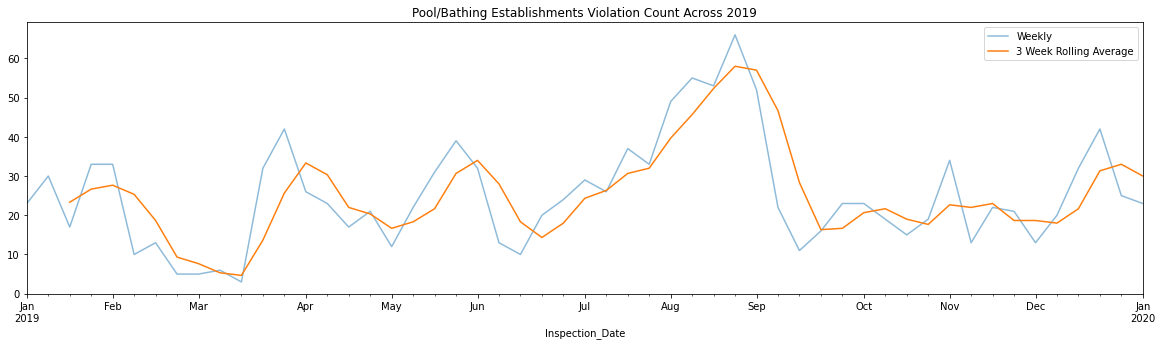

In [ ]:
ax1 = table4['# of All Violations'].plot(title='Pool/Bathing Establishments Violation Count Across 2019', alpha=0.5, figsize=(20,5))
table4['# of All Violations'].rolling(3).mean().plot(ax=ax1)
ax1.legend(["Weekly", "3 Week Rolling Average"])

# Does not seem like # of violations depends on time of year...
# Least number of violations in early March. 
# Most violations are in early April, around start of June, late August (most @ end of August), and near end of year (Maybe people getting slack around X-mas)

In [ ]:
# I want to observe the time with the most violations more closely (timeframe looks to be around August 1st to September 12th)
start_date = pd.to_datetime('2019-08-01')
end_date = pd.to_datetime('2019-09-12')
pool_inspections_08012019_09122019 = pool_inspections.loc[(pool_inspections['Inspection_Date'] > start_date) & (pool_inspections['Inspection_Date'] < end_date)]
pool_inspections_08012019_09122019

,Permit_Type,ACCELA,Facility_Name,ADDRESS_ No,ADDRESS_St,BO,ZIP,Inspection_Date,Inspection_Type,# of All Violations,# of PHH Violations,# of Critical Violations,# of General Violations,DOCKET,Lat,Long,X,Y,X_Property_Coordinate,Y_Property_Coordinate,Community Board,Council District,Census tract,BIN,NTA
38,Indoor,40425459,VILLAGE EAST TOWERS INC.,411,EAST 10 STREET,Manhattan,10009,2019-09-05,Routine Inspection,4,2,1,1,17184-19S0,40.725621,-73.976910,990650.0,203643.0,990771.0,203810.0,3.0,2.0,28.0,1078024.0,Lower East Side
69,Indoor,40425542,340 EAST 93RD STREET CORP. PLYMOUTH TOWERS CLUB,340,EAST 93 STREET,Manhattan,10128,2019-08-26,Complaint Inspection,0,0,0,0,NaN,40.781494,-73.946591,999041.0,224003.0,999010.0,223887.0,8.0,5.0,154.0,1078668.0,Yorkville
70,Indoor,40425544,CONCORDE HEALTH CLUB CORP,220,EAST 65 STREET,Manhattan,10021,2019-09-10,Routine Inspection,1,1,0,0,17385-19S0,40.765021,-73.963193,994446.0,217999.0,994594.0,217785.0,8.0,4.0,118.0,1043869.0,Lenox Hill-Roosevelt Island
103,Indoor,40425642,THE FITNESS PLACE BAYRIDGE INC,430,89 STREET,Brooklyn,11209,2019-08-07,Routine Inspection,1,0,1,0,15339-19S0,40.620203,-74.028727,976275.0,165237.0,976351.0,165110.0,10.0,43.0,160.0,3154220.0,Bay Ridge
104,Indoor,40425642,THE FITNESS PLACE BAYRIDGE INC,430,89 STREET,Brooklyn,11209,2019-08-27,Re-Inspection,1,0,1,0,15339-19S1,40.620203,-74.028727,976275.0,165237.0,976351.0,165110.0,10.0,43.0,160.0,3154220.0,Bay Ridge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,Outdoor,50079140,CASTLETON PRESERVATION LLC,185,SAINT MARKS PLACE,Staten Island,10301,2019-08-26,Re-Inspection,0,0,0,0,NaN,40.645351,-74.080729,961847.0,174408.0,961987.0,174640.0,1.0,49.0,7.0,5108502.0,West New Brighton-New Brighton-St. George
1260,Outdoor,50082223,LINDSAY PARK HOUSING CORP,67,MANHATTAN AVENUE,Brooklyn,11206,2019-08-05,Routine Inspection,4,0,1,3,15221-19S0,40.704692,-73.944525,999631.0,196022.0,999417.0,195981.0,1.0,34.0,491.0,3338422.0,East Williamsburg
1262,Outdoor,50092731,THORJAMES HOTEL LEASECO LLC,27,GRAND STREET,Manhattan,10013,2019-08-07,Routine Inspection,0,0,0,0,NaN,40.722820,-74.004726,982940.0,202622.0,982900.0,202535.0,2.0,1.0,47.0,1088405.0,SoHo-TriBeCa-Civic Center-Little Italy
1264,Outdoor,50094656,LINDSAY PARK HOUSING CORP,46,BOERUM STREET,Brooklyn,11206,2019-08-10,Routine Inspection,3,0,2,1,15599-19S0,40.705472,-73.947482,998811.0,196306.0,998975.0,195962.0,1.0,34.0,491.0,3327971.0,East Williamsburg


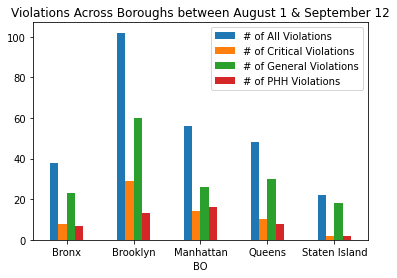

In [ ]:
table_e = pd.pivot_table(data=pool_inspections_08012019_09122019, 
                        index='BO', 
                        values=['# of All Violations','# of PHH Violations','# of Critical Violations','# of General Violations'], 
                        aggfunc=np.sum)
table_e.plot(kind='bar', title='Violations Across Boroughs between August 1 & September 12', rot=0)
# From the plot, it seems that something may have happened in Brooklyn between August 1st & September 12th,
# that caused the pools & bathing establishment to commit more violations. 
# Unfortunately, from just this data alone, we can't tell what happened.

In [ ]:
# Do the quantity of violations depend on location/area?
# to make a folium map of locations & number of violations
# first, set up a dataframe with facility name, sum of violations, lat, long
pool_inspections_rd = pool_inspections.drop_duplicates('ACCELA') # 'ACCELA' to replace 'Facility_Name'
pool_inspections_rdsf = pool_inspections_rd.sort_values('Facility_Name') # so that it matches with table1 which is ordered by Facility_Name
pool_inspections_rdsf.drop('Inspection_Date', inplace=True, axis=1) # removing columns that turn inaccurate after removing duplicates
pool_inspections_rdsf.drop('Inspection_Type', inplace=True, axis=1)

pool_inspections_rdsf['# of All Violations'] = table1['# of All Violations'].values # different indices b/w dataframes, so used .values to get just the values
pool_inspections_rdsf['# of Critical Violations'] = table1['# of Critical Violations'].values
pool_inspections_rdsf['# of General Violations'] = table1['# of General Violations'].values
pool_inspections_rdsf['# of PHH Violations'] = table1['# of PHH Violations'].values


In [ ]:
pool_inspections_rdsf.isnull().sum() # to check if Lat & Long have any nulls that would get in the way of making maps

Permit_Type                   0
ACCELA                        0
Facility_Name                 0
ADDRESS_ No                   0
ADDRESS_St                    0
BO                            0
ZIP                           0
# of All Violations           0
# of PHH Violations           0
# of Critical Violations      0
# of General Violations       0
DOCKET                      669
Lat                           3
Long                          3
X                             3
Y                             3
X_Property_Coordinate        61
Y_Property_Coordinate        61
Community Board              61
Council District             61
Census tract                 61
BIN                          84
NTA                          61
dtype: int64

In [ ]:
pool_inspections_rdsf = pool_inspections_rdsf.dropna(subset=['Lat','Long']) # dropping the rows with null values in Lat & Long

In [ ]:
# to include multiple variables/values into the folium map markers by using concatenation:
pool_inspections_rdsf['Location_Info'] = pool_inspections_rdsf['Facility_Name'] + " Address: " + pool_inspections_rdsf["ADDRESS_ No"] + " " + pool_inspections_rdsf["ADDRESS_St"] + ", " + pool_inspections_rdsf["BO"] + ", ZIP: " + pool_inspections_rdsf['ZIP'].astype(str) + " Total_Violations: " + pool_inspections_rdsf['# of All Violations'].astype(str) + " PHH_Violations: " + pool_inspections_rdsf['# of PHH Violations'].astype(str) + " Critical_Violations: " + pool_inspections_rdsf['# of Critical Violations'].astype(str) + " General_Violations: " + pool_inspections_rdsf['# of General Violations'].astype(str)

In [ ]:
pool_inspections_rdsf['Location_Info'].head(3)

1234    1 BEACH 105 REALTY LLC Address: 1 BEACH 105 ST...
859     10 MADISON SQUARE WEST Address: 10 MADISON SQU...
644     10 WEST END AVENUE CONDOMINIUM Address: 10 WES...
Name: Location_Info, dtype: object

In [ ]:
map = folium.Map(location=[pool_inspections_rdsf["Lat"].mean(), pool_inspections_rdsf["Long"].mean()], # deciding center of the map
                 zoom_start=11, # initial zoom level for map
                 control_scale=True) # adding a control scale to map

for index, location in pool_inspections_rdsf.iterrows():
    folium.Marker([location["Lat"], location["Long"]], popup=location["Location_Info"]).add_to(map)

#map

In [ ]:
# to add a heatmap to the folium map
df = pd.DataFrame(pool_inspections_rdsf[['Lat', 'Long', '# of All Violations']]) # creating a new dataframe out of columns from a old one
data = df.values.tolist() # turning a dataframe into a list of lists

color_gradient = {
    0.0 : 'blue',
    0.2 : 'green',
    0.5 : 'yellow',
    0.8 : 'orange',
    1.0 : 'red'
}

HeatMap(data, gradient=color_gradient).add_to(map) # adding a heatmap to the folium map

In [ ]:
map
# It seems that although there are places with relatively more violations along the edges of the boroughs, 
# more locations near the inner parts of the boroughs have more violations. 
# It seems Manhattan has the most facilities with high numbers of violations, but this could be because Manhattan has the most facilities recorded.

In [ ]:
# Conclusion
# My hypothesis was wrong. Locations in the more inner parts of the boroughs have more pool/bathing establishment violations,
# while there are a lesser number of violations around the edges. 
# And the largest number of violations did not occur during winter (between December and March), but instead between August and September. 
# After analyzing the data, my conclusion is that I cannot come to any concrete conclusions on the overall picture. 
# Although from the data, most violations seemed to have occurred in Manhattan, 
# but that may be because most of the facilities that were inspected were in Manhattan.
# Contrarily, during the time period where there were the most violations, the largest amount of violations appeared in Brooklyn,
# which has less than half the number of recorded facilities that Manhattan does. 
# Although from the data, it seems like August and September may be the worst months to go to pools and bathing establishments,
# that is only for 2019. 
# Data from other years would be required to tell whether or not that is consistently true. Unfortunately, I have yet to see such datasets. 
# But at the very least, I do NOT recommend that people go to the bottom-most facilities in the sorted table1: 
table1.sort_values('# of All Violations').tail()


,,,# of All Violations,# of Critical Violations,# of General Violations,# of PHH Violations
Facility_Name,ACCELA,BO,,,,
TCR TENNIS CLUB OF RIVERDALE INC,41380939,Bronx,13,4,5,4
FITNESS INTERNATIONAL LLC,50033544,Queens,16,4,4,8
L. A. FITNESS INTERNATIONAL LLC,41269465,Staten Island,16,5,7,4
TOWN SPORTS INTERNATIONAL,41284561,Bronx,17,15,0,2
PARK AVENUE HEALTH CLUB LLC,41130846,Brooklyn,34,9,0,25
